In [1]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 34.8MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577193 sha256=bc5eecb1d11133529d31c8c201daea4c4a1ddbdd611141b578fca83f540273d4
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [4]:
!git clone https://github.com/slinderman/ssm.git

Cloning into 'ssm'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2139 (delta 73), reused 80 (delta 42), pack-reused 2016
Receiving objects: 100% (2139/2139), 16.47 MiB | 1.05 MiB/s, done.
Resolving deltas: 100% (1466/1466), done.


In [5]:
%cd ssm
!pwd

/content/ssm
/content/ssm


In [6]:
!pip install -e .

Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [0]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN

In [0]:
import sys

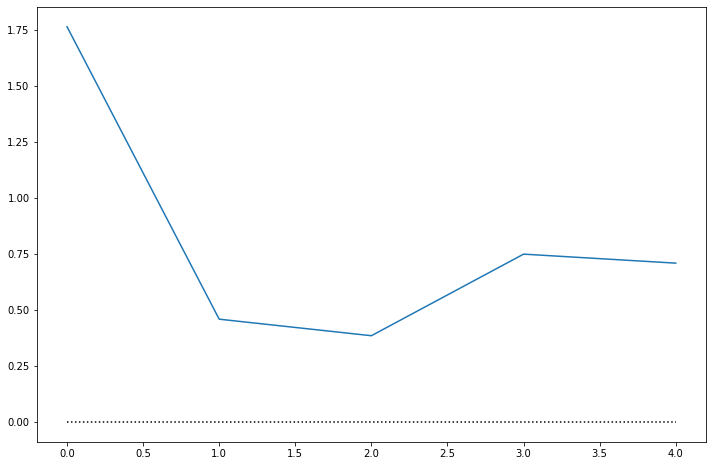

In [10]:
npr.seed(0)
N = 1
T = 5
dt = 1.0
# W = npr.randn(N, N) / (10 * N)
# B = npr.randn(N, 1)
# u = 0.1 * npr.randn(T, 1)
#W = np.array([[0.95]])
W = np.array([[0.2]])
B = np.zeros((N, 1))
u = np.zeros((T, 1))
x0 = npr.randn(N)
sigma = 0.3

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Sample the vanilla RNN
x = np.zeros((T,N))
x[0] = x0
for t in range(1, T):
    x[t] = np.tanh(W @ x[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)

plt.figure(figsize=(12, 8))
plt.plot(x + 2 * np.arange(N))
for n in range(N):
    plt.plot(2 * n * np.ones(T), ":k")

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



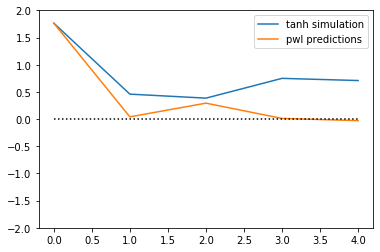

In [0]:
# Sample the vanilla RNN
pwl_tanh = PiecewiseLinearTanh(num_parts=16)
xpred = np.zeros((T, N))
xpred[0] = x0
for t in range(1, T):
    xpred[t] = pwl_tanh.f(W @ xpred[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)

plt.plot(x, label="tanh simulation")
plt.plot(xpred, label='pwl predictions')
plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

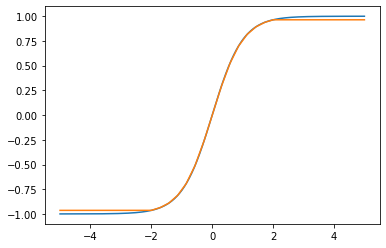

In [0]:
xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))

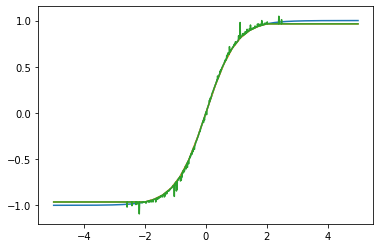

In [0]:
pwl_tanh = PiecewiseLinearTanh()
spwl_tanh = StochPiecewiseLinearTanh(num_parts=16, temp=0.25)

xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))
plt.plot(xx, spwl_tanh.f(xx))

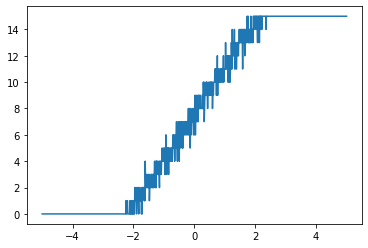

In [0]:
plt.plot(xx, spwl_tanh.f(xx, return_z=True)[1])

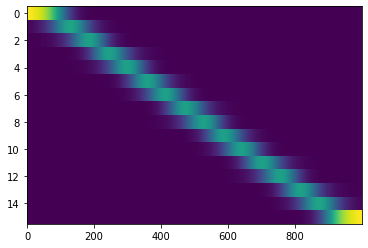

In [0]:
plt.imshow(spwl_tanh.discrete_prior(xx).T, aspect="auto")

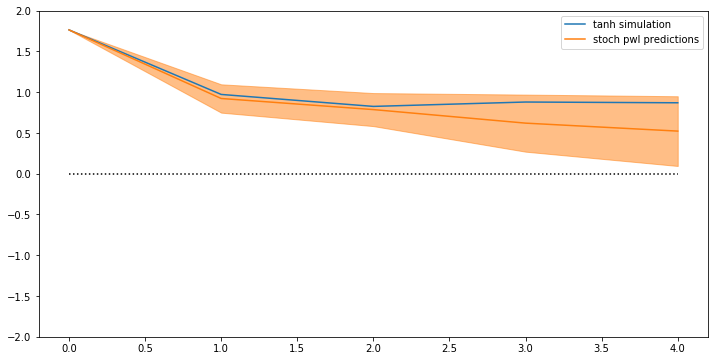

In [0]:
# Sample the stochastic pwl tanh RNN
n_samples = 10
xpreds = np.zeros((n_samples, T, 1))
zpreds = np.zeros((n_samples, T), dtype=int)
for n in range(n_samples):
  xpreds[n, 0] = x0
  for t in range(1, T):
      # yhat, zpreds[n, t] = spwl_tanh.f(w * xpreds[n, t-1] + b, return_z=True)
      mu_pred, zpreds[n, t] = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t], return_z=True)
      xpreds[n, t] = mu_pred + np.sqrt(dt) * sigma * npr.randn(N)

xpred_mean = np.mean(xpreds, axis=0)[:, 0]
xpred_std = np.std(xpreds, axis=0)[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(x, label="tanh simulation")
h = plt.plot(xpred_mean, label='stoch pwl predictions')[0]
plt.fill_between(np.arange(T), 
                 xpred_mean - 2 * xpred_std, 
                 xpred_mean + 2 * xpred_std,
                 color=h.get_color(),
                 alpha=0.5)

plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

In [0]:
spwl_tanh = StochPiecewiseLinearTanh()
zsmpls, msmpls, Vsmpls = spwl_tanh.resample(xpreds[0, :-1, 0], xpreds[0, 1:, 0], dt * sigma**2)



# # Combine the Gaussian potentials into one
# Jsmpls = 1 / Vsmpls
# hsmpls = msmpls / Vsmpls
# Jeff = Jsmpls.sum(axis=1)
# heff = hsmpls.sum(axis=1)
# meff = heff / Jeff
# Veff = 1 / Jeff


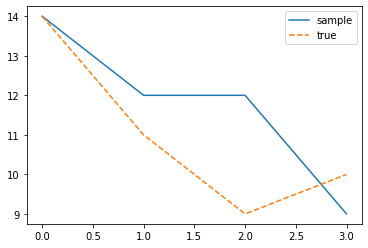

In [0]:
plt.plot(zsmpls, label="sample")
plt.plot(zpreds[0, 1:], '--', label="true")
plt.legend()

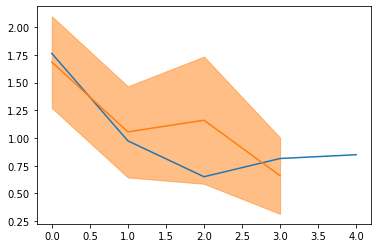

In [0]:
plt.plot(xpreds[0])
h = plt.plot(msmpls)[0]
plt.fill_between(np.arange(T-1), 
                 msmpls - 2 * np.sqrt(Vsmpls), 
                 msmpls + 2 * np.sqrt(Vsmpls),
                 color=h.get_color(),
                 alpha=0.5)

In [0]:
# Define the piecewise linear tanh approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self, num_parts=16, window=4, temp=0.25):
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp


        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

        self.cond_z=0


    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)

        if return_z:
            return self.intercepts[z] + self.slopes[z] * x, z
        else:
            return self.intercepts[z] + self.slopes[z] * x

    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)
        assert x.ndim == 1
        N, = x.shape

        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.

        s = sigmoid((x[:, None] - self.knots[None, :]) / self.temp)
        oms = 1 - s

        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((N, self.num_parts))
        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]
            prior[:, k] = np.prod(s[:, ik[bk==1]], axis=1) * \
                          np.prod(oms[:, ik[bk==0]], axis=1)
        return prior

    def resample_discrete_states(self, x, y, sigmasq):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)

        N, = x.shape
        y = np.reshape(y, (N,))

        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Compute log likelihood (up to constant) under each discrete state
        yhat = x[:, None] * self.slopes + self.intercepts
        log_lkhd = -0.5 * (y[:, None] - yhat)**2 / sigmasq

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=1, keepdims=True))

        self.cond_z = post        
        

        # Sample the posterior
        z = np.array([npr.choice(self.num_parts, p=pn) for pn in post])
        
        

        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        

        b = self._bs[z]
        i = self._inds[z]
        
        u = (x[:, None] - self.knots[i]) / self.temp


        # Sample the auxiliary variable and compute the potential on u
        
        #### TODO: Sample rather than just returning the mean
        #Ju = np.tanh(u / 2) / (2 * u)
        
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)

        hu = b - 0.5

        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju

        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2

        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx
        return mx, Vx

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, y, sigmasq)
        bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx


class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, (y + 1) / 2, sigmasq / 4)

        return zs, mx / 2, Vx / 4

    def recurrence_potentials(self, x0, z, u, W, B, sigmasq):
      '''
      x_t ~ N(A_tx_{t-1}+B_tilde_t u_tilde_t)
      A_t = 4slopes[z]W
      B_tilde_t = [4slopes[z]B, 2ints[z]-1]
      u_tilde_t = [u_t^T,1]^T
      '''
      A = 4*self.slopes[z]*W
      uTBT = u[1:]*(4*self.slopes[z]*B)[:,None]+(2*self.intercepts[z]-1)[:,None]
      uTBT = uTBT.reshape(uTBT.shape[0],)
    
      J_ini = 1/sigmasq
      

      J_dyn_11 = A[1:]*1/sigmasq*A[1:]
      J_dyn_21 = -A[1:]*1/sigmasq
      J_dyn_22 = 1/sigmasq

      
      h_ini = 1/sigmasq*(A[0]*x0+uTBT[0])
      h_dyn_1 = -uTBT[1:]*1/sigmasq*A[1:]
      h_dyn_2 = uTBT[1:]*1/sigmasq

      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2   

    def obs_potentials(self, y, C, sigma_y_sq):
      J_obs = C*1/sigma_y_sq*C 
      h_obs = y*1/sigma_y_sq*C 
      h_obs = h_obs.reshape(h_obs.shape[0],)
      return J_obs, h_obs

    def weight_recurrence_potentials(self,r,rrT,x,zs,sigmasq):
      J = ((4*self.slopes[zs])**2*1/sigmasq)[:,None,None]*rrT #shape=(T,d,d)
      c = (x[1:,0]-(2*self.intercepts[zs]-1))*1/sigmasq*4*self.slopes[zs] #shape=(T,d)
      h = c[:,None]*r
      return J, h


    def gibbs_iteration(self,x,y,u,W,B,C,sigma,Wbar_prior, Wbar_sigma, train_weights):
      # 1. Sample discrete states and auxiliary variables given continuous states x.
      #    First compute the input to the tanh  
      inx = x[:-1] @ W.T + u[1:] @ B.T
      zs, ms, Vs = spwl_tanh.resample(inx[:,0], x[1:,0], sigma**2)

      '''
      #################
      ####z unit tests
      zs, ms, Vs = spwl_tanh.resample(inx[:,0], x[1:,0], sigma**2)  
      print(zs)
      print(self.cond_z)
      log_cond1 = np.sum(np.log(self.cond_z[np.arange(len(zs)),zs]))
      log_joint1 = self.log_joint(y, x, zs, W, B, u, C, sigma, Wbar_prior, Wbar_sigma)


      
      zs, ms, Vs = spwl_tanh.resample(inx[:,0], x[1:,0], sigma**2)  
      print(zs)
      print(self.cond_z)
      log_cond2 = np.sum(np.log(self.cond_z[np.arange(len(zs)),zs]))
      log_joint2 = self.log_joint(y, x, zs, W, B, u, C, sigma, Wbar_prior, Wbar_sigma)

      print('z')
      print('log_joint1-log_joint2')
      print(log_joint1-log_joint2)
      print('log_cond1-log_cond2')
      print(log_cond1-log_cond2)
      sys.exit()
      #################
      '''

     
      # Convert mean and variance on Wx + Bu to mean and variance on x
      J_tildes = W[0,0]*1/Vs[1:]*W[0,0] 
      #V_tildes = 1/J_tildes
      #m_tildes = V_tildes * W[0,0] *1/Vs[1:]*(ms[1:]-B[0,0]*u[2:,0])
      h_tildes = W[0,0] *1/Vs[1:]*(ms[1:]-B[0,0]*u[2:,0])


      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      # Combine Gaussian potential from auxiliary variables with potentials from
      # dynamics and emissions.  Then sample the Gaussian posterior. 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2  = spwl_tanh.recurrence_potentials(x[0], zs, u, W[0,0],B[0,0], sigma**2)
      J_obs, h_obs = spwl_tanh.obs_potentials(y, C, 1)

      #Combine discrete/auxiliary potentials with recurrence potentials:
      J_dyn_11 += J_tildes
      h_dyn_1 += h_tildes
      
      #sample continuous states x using message passing:
      #fix 1d shapes
      J_obs = np.atleast_1d(np.ones(T-1)*J_obs).reshape(-1,1,1)
      h_obs = h_obs[:,None]
      J_ini = np.atleast_1d(J_ini)[:,None]
      J_dyn_11 = J_dyn_11.reshape(-1,1,1)
      J_dyn_21 = J_dyn_21.reshape(-1,1,1)
      J_dyn_22 = np.atleast_1d(J_dyn_22)[:,None]
      h_dyn_1 = h_dyn_1[:,None]
      h_dyn_2 = h_dyn_2[:,None]
      
      
      log_Z_obs = np.zeros(y.shape[0])
      x = messages.kalman_info_sample(J_ini, h_ini, 0, J_dyn_11, J_dyn_21,     
                                        J_dyn_22, h_dyn_1, h_dyn_2, 0,           
                                        J_obs, h_obs, log_Z_obs) 

      #Concatenate initial state
      x = np.concatenate((x0[:,None], x))


      ########
      if train_weights == True:
      #Sample Weights
      #1. Convert mean and variance on Wx+Bu from augmented potentials to mean and variance on W_bar = [W,B], using r_t=[x_{t-1},u_t]
        r = np.concatenate((x[:-1], u[1:]), axis=1)
        rrT = r[...,None]*r[:,None,:]

        J_tildes = 1/Vs[:,None,None]*rrT  #shape=(T,d,d)
        h_tildes = r*1/Vs[:,None]*ms[:,None] #shape=(T,d)

       
        #Get recurrence potentials
        J_W, h_W = self.weight_recurrence_potentials(r,rrT,x,zs,sigma**2)
        
        #Combine all terms
        prior_sigma_inv = np.diag(1/(Wbar_sigma**2))
        
        J_W = np.sum(J_W+J_tildes, axis=0)+prior_sigma_inv  
        h_W = np.sum(h_W+h_tildes,axis=0)+(prior_sigma_inv @ Wbar_prior)

        #convert to mean parameters
        V_W = np.linalg.inv(J_W)
        W_mu = V_W @ h_W

        L = np.linalg.cholesky(V_W)
        W_bar = W_mu + L@npr.randn(W_mu.shape[0])

        '''
        ######
        #W_bar unit tests
        W_bar1 = W_mu + L@npr.randn(W_mu.shape[0])
        log_cond1 = MVN.logpdf(W_bar1, W_mu, V_W)
        W = W_bar1[0].reshape(1,1)
        B = W_bar1[1].reshape(1,1)
        log_joint1 = self.log_joint(y, x, zs, W, B, u, C, sigma, Wbar_prior, Wbar_sigma)
        Wr =np.sum(W_bar1 * r, axis=1)
        log_joint1 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))
       


        W_bar2 = W_mu + L@npr.randn(W_mu.shape[0])
        log_cond2 = MVN.logpdf(W_bar2, W_mu, V_W)
        W = W_bar2[0].reshape(1,1)
        B = W_bar2[1].reshape(1,1)
        log_joint2 = self.log_joint(y, x, zs, W, B, u, C, sigma, Wbar_prior, Wbar_sigma)
        Wr =np.sum(W_bar2 * r, axis=1)
        log_joint2 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))

        print('Wbar')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
        sys.exit()
        ####
        '''

        #Extract W and B
        W = W_bar[0].reshape(1,1)
        B = W_bar[1].reshape(1,1)

      return x,W,B,zs

    def gewecke_iteration(self,x,y,u,W,B,C,sigma,Wbar_prior, Wbar_sigma,train_weights):
      #Sample discrete and auxiliary variables to then sample continous state x
      x,W,B,zs = self.gibbs_iteration(x,y,u,W,B,C,sigma,Wbar_prior, Wbar_sigma, train_weights)

      #Resample ys for Gewecke testing
      y = C*x[1:] + npr.randn(*x[1:].shape)
      return x,W,B,zs,y 


    def x_log_prior(self,inx, x, z, sigma):
      mu = 2*(self.intercepts[z]+self.slopes[z]*2*inx)-1
      scale = sigma*np.ones(mu.shape)
      return norm.logpdf(x[1:,0],mu,scale)

    def y_log_prior(self, y, x, C):
      mu = C*x[1:]
      return norm.logpdf(y,loc=mu)

    def wbar_log_prior(self, W, B, mu_prior, sigma_W):
      W_bar = np.array([W[0,0], B[0,0]])#np.concatenate((W[0,0],B[0,0]))
      return norm.logpdf(W_bar, mu_prior, sigma_W)

    def log_joint(self, y, x, z, W, B, u, C, sigma, Wbar_prior, sigma_W):
      inx = x[:-1] @ W.T + u[1:] @ B.T
      log_like = 0
      log_like += np.sum(self.x_log_prior(inx[:,0], x, z, sigma))
      print('x_log_like')
      print(np.sum(self.x_log_prior(inx[:,0], x, z, sigma)))
      #log_like += np.sum(np.log(self.discrete_prior(2*inx[:,0])[np.arange(len(z)),z]))
      #print('z_log_like')
      #print(np.sum(np.log(self.discrete_prior(2*inx[:,0]))))
      log_like += np.sum(self.y_log_prior(y, x, C))
      print('y_log_like')
      print(np.sum(self.y_log_prior(y, x, C)))
      log_like += np.sum(self.wbar_log_prior(W, B, Wbar_prior, sigma_W))
      print('Wbar log like')
      print(np.sum(self.wbar_log_prior(W, B, Wbar_prior, sigma_W)))
      return log_like

# Run Gibbs sampler 

In [0]:
seed = np.random.randint(low=0, high=1000000)
#seed = 3
npr.seed(seed)
N = 1
T = 4
dt = 1.0
# W = npr.randn(N, N) / (10 * N)
# B = npr.randn(N, 1)
# u = 0.1 * npr.randn(T, 1)
#W = np.array([[0.95]])
W = np.array([[0.2]])
B = 0.1*np.ones((N, 1))
u = 0.2*np.ones((T, 1))
x0 = npr.randn(N)
sigma = 0.3


# Sample the vanilla RNN
x = np.zeros((T,N))
x[0] = x0
for t in range(1, T):
    x[t] = np.tanh(W @ x[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)


prior_iters = 10000
num_iters = 10000
burn_rate = .8
burn_iters = int(burn_rate*num_iters)
train_weights=True
Wbar_prior = np.zeros(2) #prior mean
Wbar_sigma = .3*np.ones((2))
C=1
y = C*x[1:] + npr.randn(*x[1:].shape)

In [30]:
#Gewecke Testing Weights Trained
spwl_tanh = StochPiecewiseLinearTanh()

#Burn-in period
for i in range(burn_iters):
  x,W,B,z,y = spwl_tanh.gewecke_iteration(x,y,u,W,B,C,sigma,Wbar_prior, Wbar_sigma, train_weights)
  print(i)


x_samples = np.zeros((num_iters-burn_iters,T,1))
W_samples = np.zeros((num_iters-burn_iters,1))
B_samples = np.zeros((num_iters-burn_iters,1))
z_cnts = 0
#Sample after chain has hopefully converged to stationary distribution
for i in range(0,num_iters-burn_iters):
  x,W,B,z,y = spwl_tanh.gewecke_iteration(x,y,u,W,B,C,sigma,Wbar_prior, Wbar_sigma,train_weights)
  x_samples[i] = x
  W_samples[i] = W[0,0]
  B_samples[i] = B[0,0]
  z_cnts += z
  print(i)

Ez = z_cnts/(num_iters-burn_iters)

#Sample from prior:
xpreds = np.zeros((prior_iters, T, 1))
zpreds = np.zeros((prior_iters,T-1))
Wbar_preds = np.zeros((prior_iters,2))
for n in range(prior_iters):
  xpreds[n, 0] = x0
  if train_weights==True:
    Wbar = Wbar_prior + Wbar_sigma*npr.randn(2)
    Wbar_preds[n] = Wbar
    W = Wbar[0].reshape(1,1)
    B = Wbar[1].reshape(1,1)
  
  for t in range(1, T):
      mu_pred,z = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t],return_z=True)
      xpreds[n, t] = mu_pred + np.sqrt(dt) * sigma * npr.randn(N)
      zpreds[n,t-1] = z


prior_z_avg = np.sum(zpreds,axis=0)/(prior_iters)
print(n)

print('Prior_z_avg:')
print(prior_z_avg)
print('gibbs Ez')
print(Ez)

print('Prior Wbar avg')
prior_Wbar_avg = np.sum(Wbar_preds,axis=0)/prior_iters
print(prior_Wbar_avg)

print('gibbs W avg')
W_avg = np.sum(W_samples)/(num_iters-burn_iters)
B_avg = np.sum(B_samples)/(num_iters-burn_iters)
print('gibbs W avg')
print(W_avg)
print('gibbs B avg')
print(B_avg)


Streaming output truncated to the last 5000 lines.
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202

(2000, 3)
(10000, 3)


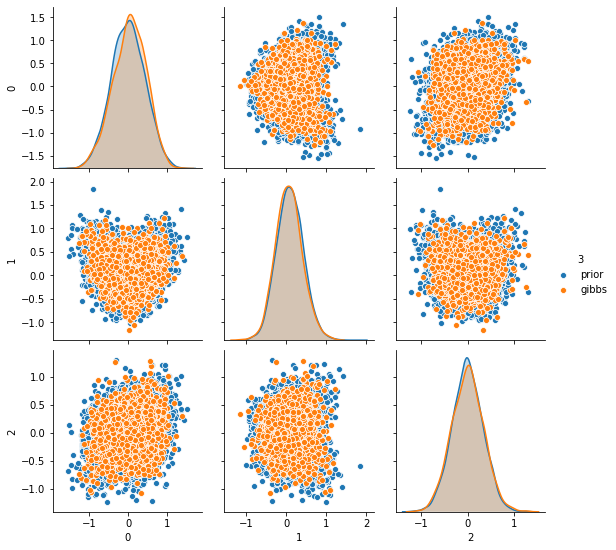

In [31]:
#Pairwise Plots of Gewecke Results Weights Trained

x_samples = np.squeeze(x_samples)
xpreds = np.squeeze(xpreds)

print(x_samples[:,1:].shape)
print(xpreds[:,1:].shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')


(600000, 4)
(3000000, 4)


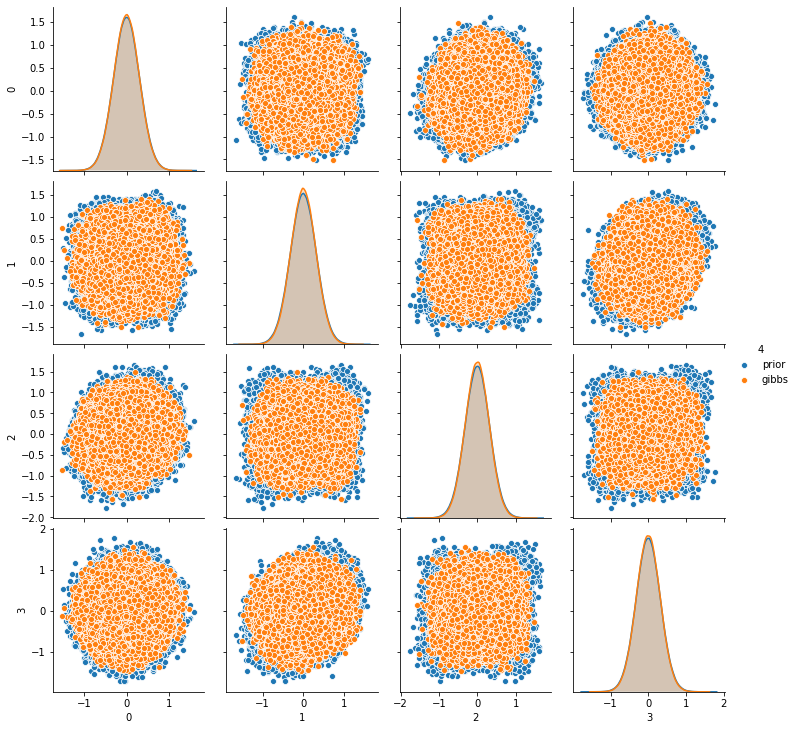

In [0]:
#Pairwise Plots of Gewecke Results Weights Trained

x_samples = np.squeeze(x_samples)
xpreds = np.squeeze(xpreds)

print(x_samples[:,1:].shape)
print(xpreds[:,1:].shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')


(300000, 4)
(1000000, 4)


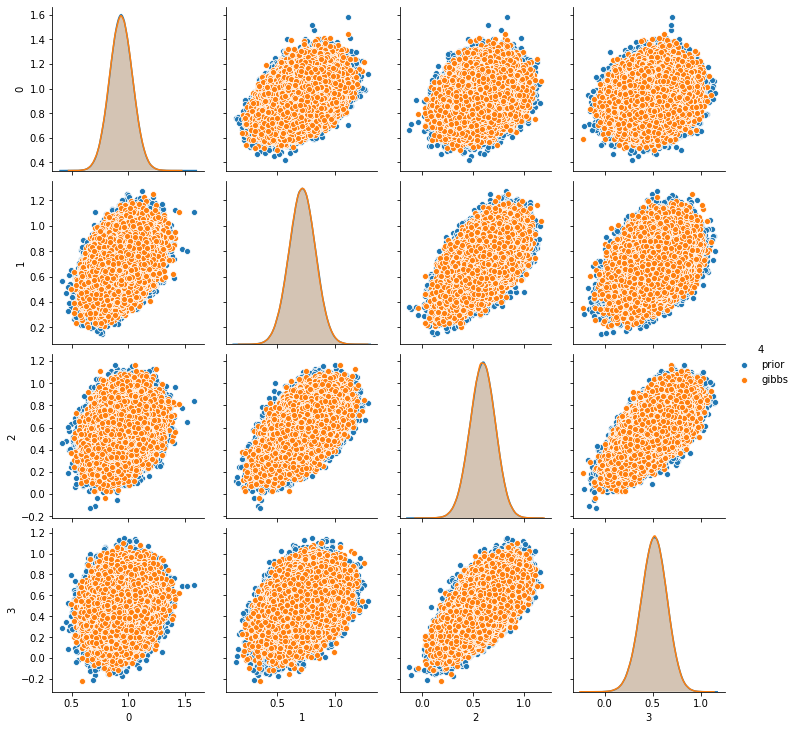

In [0]:
#Pairwise Plots of Gewecke Results Weights Frozen

x_samples = np.squeeze(x_samples)
xpreds = np.squeeze(xpreds)

print(x_samples[:,1:].shape)
print(xpreds[:,1:].shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')